In [ ]:
%matplotlib notebook

#importing the useful libraries
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

#to check the version of the tensorflow
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


In [ ]:
#we will be using mnist dataset for the project
#loading the data with the dataset function in keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#normalize the data and unrolling the images
x_train = np.reshape(x_train, (x_train.shape[0], 28*28))/255.
x_test = np.reshape(x_test, (x_test.shape[0], 28*28))/255.

#one hot encodeing the labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print(x_train.shape, y_train.shape)

(60000, 784) (60000, 10)


In [ ]:
#creating the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation = 'relu', input_shape = (784,)),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

opt = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#creating the custom callbacks
#we will use the callback class from keras and overwrite it according to the need
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, fraction):
        #fraction will be multiplied with the learning rate while updating
        super(CustomCallback, self).__init__()
        
        self.fraction = fraction
        self.train_a = []
        self.val_a = []
        
        with open('log.txt','w') as f:
            f.write('Start of logging..\n')
            
        self.fig = plt.figure(figsize=(4,3))
        self.ax = plt.subplot(1,1,1)
        plt.ion()
        
    #this will help to plot the training and validation metrics canvas
    def on_train_begin(self, logs = None):
        self.fig.show()
        self.fig.canvas.draw()
            
    #this will modify the training end callback function and will allow us to write the log after training
    def on_train_end(self, logs = None):
        with open('log.txt','a') as f:
            f.write('End of logging..\n')
            
    #this will modify the epoch begin so that we will have a callback that will modify the learning rate, with the increase in epochs
    def on_epoch_begin(self, epoch, logs = None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        #to get the current learning rate value
        lr*= self.fraction
        #to set the updated learning rate
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        with open('log.txt','a') as f:
            f.write('At epoch {:02d}, learning rate changed to {:.4f}\n'.format(epoch, lr))
    
    #this will update the log file at the end of epochs with the training and validtion accuracy
    def on_epoch_end(self, epoch, logs =None):
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')
        
        self.val_a.append(val_acc)
        self.train_a.append(train_acc)
        
        with open('log.txt','a') as f:
            f.write('At epoch {:02d}, training accuracy: {:3f}, validation accuracy: {:.3f}'.format(epoch, train_acc, val_acc))
    
        #for plotting the validation and training accuracy after every epochs
        self.ax.clear()
        self.ax.plot(range(1+ epoch), self.train_a, label='training')
        self.ax.plot(range(1+epoch), self.val_a, label = 'validation')
        self.ax.set_xlabel('Epochs')
        self.ax.set_ylabel('Accuracy')
        self.ax.legend()
        self.fig.canvas.draw()
        #to update the canvas after every epochs
    

<IPython.core.display.Javascript object>


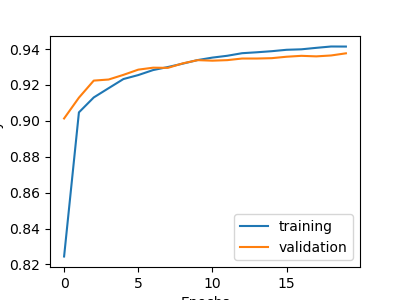

In [ ]:
cc = CustomCallback(fraction = 0.9)
#instantiation of the callbacks

In [ ]:
_ = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs = 20, verbose = False,
    callbacks=[cc]
)
#training of the model